In [1]:
import gym
import numpy as np
import random
import tensorflow as tf
import matplotlib.pyplot as plt
import scipy.misc
import os
from IPython import display
import time
import math
import cProfile
%matplotlib inline

In [2]:
def get_color(value):
    if value <= 0:
        return '#cdc1b4'
    if value <= 2:
        return '#eee4da'
    if value <= 4:
        return '#ede0c8'
    if value <= 8:
        return '#f2b179'
    if value <= 16:
        return '#f59563'
    if value <= 32:
        return '#f67c5f'
    if value <= 64:
        return '#f65e3b'
    if value <= 128:
        return '#edcf72'
    if value <= 256:
        return '#edcc61'
    if value <= 512:
        return '#edc850'
    if value <= 1024:
        return '#edc53f'
    return '#ecc02e'

In [3]:
class gameEnv():
    def __init__(self):
        self.size = 4
        self.actions = 4
        self.a = []
        self.rendered = []
        self.currReward = 0
        self.cumReward = 0
        self.reset()
        self.won = False
        self.movement = False
        self.last_action = 0
    
    def reset(self):
        arr = np.array([0 for i in range(16)])
        self.a = arr.reshape([4,4])
        self.addRandomOpen()
        self.renderEnv()
        self.currReward = 0
        self.cumReward = 0
        return self.a
        
    def addRandomOpen(self):
        indices = np.asarray(np.where(self.a == 0)).T
        choice = random.choice(indices)
        if(np.random.rand(1)<.1):
            self.a[choice[0]][choice[1]] = 4
        else:
            self.a[choice[0]][choice[1]] = 2
    
    def renderEnv(self):
        arr = np.ones([4,4])
        for i in range(16):
            arr[i//4][i%4] = self.getColor(self.a[i//4][i%4])
        return scipy.misc.imresize(arr[:,:],[84,84,1],interp='nearest')
        
    def getColor(self, val):
        if(val == 0):
            return 0
        return math.log2(val) * 23
    
    def checkEnd(self):
        if(len(np.where(self.a == 0)[0]) == 0):
            temp = self.a.flatten()
            for i in range(len(temp)):
                if(i + 4 < len(temp)):
                    if(temp[i] == temp[i+4]):
                        return False
                if((i+1)%4 != 0):
                    if(temp[i] == temp[i+1]):
                        return False
            return True
        return False
    
    # 0 - up, 1 - down, 2 - left, 3 - right
    def move(self, action):
        if(action == 0):
            self.a = np.rot90(self.a,1)
            self.a = self.mergeLeft(self.a)
            self.a = np.rot90(self.a,3)
        elif(action ==1):
            self.a = np.rot90(self.a,3)
            self.a = self.mergeLeft(self.a)
            self.a = np.rot90(self.a,1)
        elif(action == 2):
            self.a = self.mergeLeft(self.a)
        elif(action == 3):
            self.a = np.rot90(self.a,2)
            self.a = self.mergeLeft(self.a)
            self.a = np.rot90(self.a,2)        
        
        if(self.movement == True):
            self.addRandomOpen()
        else:
            self.currReward = -10
            
        return self.checkEnd()
                        
    def step(self, action):
        self.last_action = action
        done = self.move(action)
        return self.renderEnv(),self.currReward,done
    
    def checkMove(self):
        return self.movement
        
    def mergeLeft(self, arr):
        self.currReward = 0
        self.movement = False
        for i in range(4):
            stop = 0
            for j in range(1, 4):
                if arr[i][j] != 0:
                    for k in range(stop, j):
                        if(arr[i][k] == arr[i][j]):
                            arr[i][k] = arr[i][k] * 2
                            arr[i][j] = 0
                            self.currReward += arr[i][k]
                            self.movement = True
                            stop = k + 1
                            break
                        elif(arr[i][k] == 0):
                            arr[i][k] = arr[i][j]
                            arr[i][j] = 0
                            self.movement = True
                            break
                        else:
                            stop = k + 1
                            
        self.cumReward += self.currReward
        return arr
    
    def renderDisplay(self):
        size_of_image = 8
        font_size = 20
        fig, ax = plt.subplots(figsize=(size_of_image+2, size_of_image))

        for x in range(0, 4):
            for y in range(0, 4):
                ax.broken_barh([(x, 1)],
                               (y, 1),
                               facecolors=get_color(self.a[y][x]))
                ax.annotate(str(self.a[y][x]), (x, y),
                            xytext=((2*x + 1)/2, (2*y + 1) / 2),
                            fontsize=font_size,
                            horizontalalignment='center',
                            verticalalignment='center')

        # set range of plot grid
        ax.set_ylim(4, 0)
        ax.set_xlim(0, 5)

        if self.last_action == 0:
            # up
            plt.arrow(4.5, 2.2, 0.0, -0.4, fc="k", ec="k", head_width=0.1, head_length=0.1)
        elif self.last_action == 1:
            # down
            plt.arrow(4.5, 1.8, 0.0, 0.4, fc="k", ec="k", head_width=0.1, head_length=0.1)
        elif self.last_action == 2:
            # left
            plt.arrow(4.8, 2.0, -0.4, 0.0, fc="k", ec="k", head_width=0.1, head_length=0.1)
        elif self.last_action == 3:
            # right
            plt.arrow(4.3, 2.0, 0.4, 0.0, fc="k", ec="k", head_width=0.1, head_length=0.1)

        ax.annotate("Score:", (1, 1), xytext=(4.5, 0.5), fontsize=20,
                   horizontalalignment='center', verticalalignment='center')
        ax.annotate(str(self.cumReward), (1, 1), xytext=(4.5, 0.9), fontsize=20,
                    horizontalalignment='center', verticalalignment='center')    

        plt.axis('off')
        ax.grid(True)

        plt.show()

In [4]:
class Qnetwork():
    def __init__(self,h_size,prev_states):        
        #The network recieves a frame from the game, flattened into an array.
        #It then resizes it and processes it through four convolutional layers.
        self.imageIn = tf.placeholder(shape=[None,84,84,1],dtype=tf.float32)
        self.conv1 = tf.contrib.layers.convolution2d( \
            inputs=self.imageIn,num_outputs=32,kernel_size=[8,8],stride=[4,4],padding='VALID', biases_initializer=None)
        self.conv2 = tf.contrib.layers.convolution2d( \
            inputs=self.conv1,num_outputs=64,kernel_size=[4,4],stride=[2,2],padding='VALID', biases_initializer=None)
        self.conv3 = tf.contrib.layers.convolution2d( \
            inputs=self.conv2,num_outputs=64,kernel_size=[3,3],stride=[1,1],padding='VALID', biases_initializer=None)
        self.conv4 = tf.contrib.layers.convolution2d( \
            inputs=self.conv3,num_outputs=512,kernel_size=[7,7],stride=[1,1],padding='VALID', biases_initializer=None)
        
        #We take the output from the final convolutional layer and split it into separate advantage and value streams.
        self.streamAC,self.streamVC = tf.split(3,2,self.conv4)
        self.streamA = tf.contrib.layers.flatten(self.streamAC)
        self.streamV = tf.contrib.layers.flatten(self.streamVC)
        self.AW = tf.Variable(tf.random_normal([h_size//2,env.actions]))
        self.VW = tf.Variable(tf.random_normal([h_size//2,1]))
        self.Advantage = tf.matmul(self.streamA,self.AW)
        self.Value = tf.matmul(self.streamV,self.VW)
        
        #Then combine them together to get our final Q-values.
        self.Qout = self.Value + tf.sub(self.Advantage,tf.reduce_mean(self.Advantage,reduction_indices=1,keep_dims=True))
        self.predict = tf.argmax(self.Qout,1)
        
        #Below we obtain the loss by taking the sum of squares difference between the target and prediction Q values.
        self.targetQ = tf.placeholder(shape=[None],dtype=tf.float32)
        self.actions = tf.placeholder(shape=[None],dtype=tf.int32)
        self.actions_onehot = tf.one_hot(self.actions,env.actions,dtype=tf.float32)
        
        self.Q = tf.reduce_sum(tf.mul(self.Qout, self.actions_onehot), reduction_indices=1)
        
        self.td_error = tf.square(self.targetQ - self.Q)
        self.loss = tf.reduce_mean(self.td_error)
        self.trainer = tf.train.AdamOptimizer(learning_rate=0.0001)
        self.updateModel = self.trainer.minimize(self.loss)

In [5]:
class experience_buffer():
    """Used to store experiences and samples randomly to train the network."""
    def __init__(self, buffer_size=50000):
        self.buffer_size = buffer_size
        self.states = []
        self.actions = []
        self.rewards = []
        self.dones = []
        
    def add(self, states, actions, rewards, dones):
        if len(self.actions) == self.buffer_size:
            self.states = self.states[1:]
            self.actions = self.actions[1:]
            self.rewards = self.rewards[1:]
            self.dones = self.dones[1:]

        self.states.append(states)
        self.actions.append(actions)
        self.rewards.append(rewards)
        self.dones.append(dones)
        
    def sample(self, size, previous_states):
        samples = np.random.permutation(len(self.actions)-(previous_states-1)) + (previous_states-1)

        states = []
        actions = []
        rewards = []
        states_ = []
        dones = []
        for i in samples[:size]:
            temp = []
            for j in range(previous_states):
                temp.append(self.states[i - previous_states + j + 1])
            states.append(np.dstack(temp))
            actions.append(self.actions[i])
            rewards.append(self.rewards[i])
            states_.append(self.states[i+1])
            dones.append(self.dones[i])
                
        return states, actions, rewards, states_, dones

In [6]:
def updateTargetGraph(tfVars,tau):
    total_vars = len(tfVars)
    op_holder = []
    for idx,var in enumerate(tfVars[0:total_vars//2]):
        op_holder.append(tfVars[idx+total_vars//2].assign((var.value()*tau) + ((1-tau)*tfVars[idx+total_vars//2].value())))
    return op_holder

def updateTarget(op_holder,sess):
    for op in op_holder:
        sess.run(op)

In [7]:
batch_size = 100 #How many experiences to use for each training step.
update_freq = 8 #How often to perform a training step.
y = .99 #Discount factor on the target Q-values
startE = 1 #Starting chance of random action
endE = 0.1 #Final chance of random action
anneling_steps = 1 #How many steps of training to reduce startE to endE.
num_episodes = 100003 #How many episodes of game environment to train network with.
pre_train_steps = 0 #How many steps of random actions before training begins.
pre_train_steps_from_Q = False #If true, initialize buffer with steps from Q instead of random actions
max_epLength = 5000 #The max allowed length of our episode.
load_model = True #Whether to load a saved model.
path = "./Deep-Reinforcement-Learning-Project/dqn/save_data/2048/1/cont/" #The path to save our model to.
h_size = 512 #The size of the final convolutional layer before splitting it into Advantage and Value streams.
tau = 0.0001 #Rate to update target network toward primary network
previous_states=1

In [8]:
env = gameEnv()
tf.reset_default_graph()
mainQN = Qnetwork(h_size,previous_states)
targetQN = Qnetwork(h_size,previous_states)
sess = tf.Session()
load = './Deep-Reinforcement-Learning-Project/dqn/save_data/2048/1/model.cptk'
saver = tf.train.Saver()
saver.restore(sess,load)

In [ ]:
env = gameEnv()
tf.reset_default_graph()
mainQN = Qnetwork(h_size,previous_states)
targetQN = Qnetwork(h_size,previous_states)
t_start = time.time()

init = tf.initialize_all_variables()

saver = tf.train.Saver()

trainables = tf.trainable_variables()

targetOps = updateTargetGraph(trainables,tau)

myBuffer = experience_buffer()

#Set the rate of random action decrease. 
e = startE
stepDrop = (startE - endE)/anneling_steps

#arrays to save
eps_arr = []
time_arr = []
err_arr = []
annel_arr = []

#create lists to contain total rewards and steps per episode
step_list = []
reward_list = []
total_steps = 0
hero_x = 0
hero_y = 0
least_distance = 100
last_time = t_start
last_move_no_move = False
high_score = 0

#Make a path for our model to be saved in.
if not os.path.exists(path):
    os.makedirs(path)

with tf.Session() as sess:
    if load_model == True:
        print('Loading Model...')
        load = './Deep-Reinforcement-Learning-Project/dqn/save_data/2048/1/cont/model.cptk'
        saver.restore(sess,load)
        data = np.load('./Deep-Reinforcement-Learning-Project/dqn/save_data/2048/1/cont/data.npz')
        eps_arr = data['episode'].tolist()
        time_arr = data['ti'].tolist()
        err_arr = data['error'].tolist()
        annel_arr = data['anneling'].tolist()
    else:
        sess.run(init)
#     updateTarget(targetOps,sess) #Set the target network to be equal to the primary network.
    for i in range(1, num_episodes):
        #Reset environment and get first new observation
        env.reset()
        s = env.renderEnv()
        s = s.reshape([84, 84, 1])
        if(i==1):
            myBuffer.states.append(s)
        d = False
        reward_sum = 0
        step = 0
        #The Q-Network
        while step < max_epLength: #If the agent takes longer than 200 moves to reach either of the blocks, end the trial.
            step+=1
            #Choose an action by greedily (with e chance of random action) from the Q-network
            
            if np.random.rand(1) < e or total_steps < pre_train_steps:       
                a = random.randint(0,3)
            elif(last_move_no_move == True):
                a = random.randint(0,3)
            else:
                a = sess.run(mainQN.predict,feed_dict={mainQN.imageIn:[s]})[0]
            
            s1,r,d = env.step(a)
            
            last_move_no_move = False
            if(r < 0):
                last_move_no_move = True
            
            
            
            s1 = s1.reshape([84, 84, 1])
            total_steps += 1
            myBuffer.add(s1,a,r,d) #Save the experience to our episode buffer.

            if total_steps > pre_train_steps and i > 1:
                if e > endE:
                    e -= stepDrop

                if total_steps % (update_freq) == 0:
                    states, actions, rewards, state_, done = myBuffer.sample(batch_size,previous_states) #Get a random batch of experiences.
                    #Below we perform the Double-DQN update to the target Q-values
                    Q1 = sess.run(mainQN.predict,feed_dict={mainQN.imageIn:state_})
                    Q2 = sess.run(targetQN.Qout,feed_dict={targetQN.imageIn:state_})
                    end_multiplier = -(np.array(done) - 1)
                    doubleQ = Q2[range(batch_size),Q1]
                    targetQ = rewards + (y*doubleQ * end_multiplier)
                    #Update the network with our target values.
                    _ = sess.run(mainQN.updateModel, \
                        feed_dict={mainQN.imageIn:states,mainQN.targetQ:targetQ, mainQN.actions:actions})

                    updateTarget(targetOps,sess) #Set the target network to be equal to the primary network.
            reward_sum += r
            s = s1

            if d == True:
                break

        #Get all experiences from this episode and discount their rewards. 
        step_list.append(step)
        reward_list.append(env.cumReward)
        if(env.cumReward > high_score):
            print('New Highscore: ', env.cumReward)
            high_score = env.cumReward
            
        #Periodically save the model. 
        if len(reward_list) % 100 == 0:
            ti = time.time()
            eps_arr.append(i)
            time_arr.append(ti - t_start)
            err_arr.append(np.mean(reward_list[-100:]))
            annel_arr.append(e)
            if(e > .1):
                print(i, total_steps,np.mean(step_list[-100:]),np.mean(reward_list[-100:]), (ti - last_time)/60, e)
            else:
                print(i, total_steps,np.mean(step_list[-100:]),np.mean(reward_list[-100:]), (ti - last_time)/60)
            saver.save(sess,path+'model.cptk')
            np.savez(path+'data.npz', episode=eps_arr, ti=time_arr, error = err_arr, anneling = annel_arr)
            last_time = ti
        if i % 1000 == 0:
            print('----last 1000', np.mean(reward_list[-1000:]),'-----')
    saver.save(sess,path+'model-'+str(i)+'.cptk')
    np.savez(path+'data' + str(i)+ '.npz', episode=eps_arr, time=time_arr, error = err_arr, anneling = annel_arr)
print("Percent of succesful episodes: " + str(sum(reward_list)/num_episodes) + "%")

Loading Model...
New Highscore:  1304
New Highscore:  2804
New Highscore:  3052
New Highscore:  3064
New Highscore:  3172
New Highscore:  3316


In [ ]:
plt.imshow(env.renderEnv())

In [ ]:
for i in range(1):
    complete = False
    iter = 0
    env = gameEnv()
    env.renderEnv()
    r_all = 0
    while(complete == False):
        action = sess.run(mainQN.predict, feed_dict={mainQN.imageIn:[env.renderEnv().reshape([84, 84, 1])]})
        observation, reward, done = env.step(action)
        display.clear_output(wait=True)
        display.display(env.renderDisplay())
        r_all += reward
        iter += 1
        if(done):
            complete = True
            print(iter)
            print("Complete")
            print("reward: ", env.cumReward)
        time.sleep(.1)
#           plt.show()
    print("\n \n \n")

In [10]:
env = gameEnv()

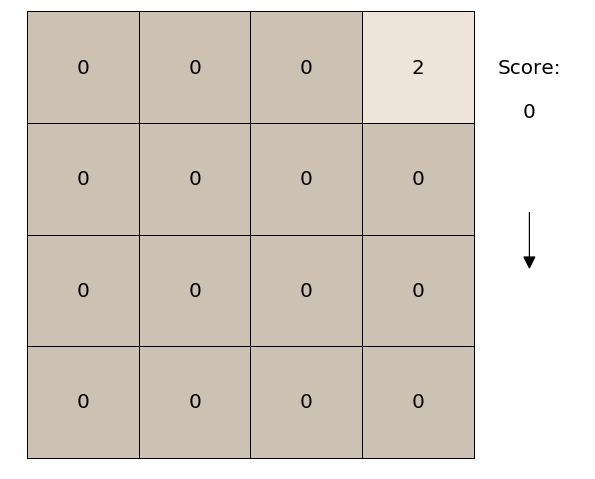

None

KeyboardInterrupt: 

In [13]:
while(env.checkEnd() ==False):
    a= int(input())
    env.step(a)
    display.clear_output(wait=True)
    display.display(env.renderDisplay())

In [12]:
env.a

array([[0, 0, 0, 2],
       [0, 0, 0, 0],
       [0, 0, 0, 0],
       [0, 0, 0, 0]])

In [60]:
stop = 0
for k in range(stop, 5):
    print(k)
    stop = k

0
1
2
3
4
